<a href="https://colab.research.google.com/github/Rahulraj31/Brain_tumor_classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center>Brain Tumor Classification </h1>

In [1]:
import PIL.Image as Image
import cv2
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/Brain_tumor.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
# Creating dataframe by iterating through filepaths
import pathlib 
tumor_dir= pathlib.Path("/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor")
healthy_dir=pathlib.Path("/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy")


In [4]:
images_dict = {
    'Cancer': list(tumor_dir.glob('*')) ,   
    'healthy': list(healthy_dir.glob('*'))  
}

labels_dict = {
    'Cancer': "cancer",
    'healthy': "healthy",
    
}

In [5]:
img= cv2.imread(str(images_dict['healthy'][0]))
img.shape

(225, 225, 3)

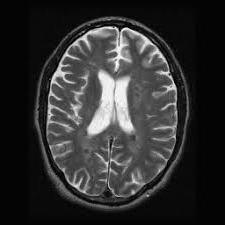

In [6]:
Image.open(str(images_dict['healthy'][100]))

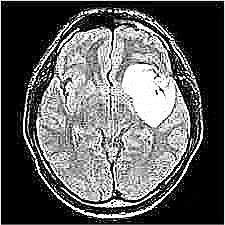

In [7]:
Image.open(str(images_dict['Cancer'][100]))

In [8]:
X, y = [], []
for name,images in images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
     
        #resize_img=cv2.resize(img,(224,224))
       
        X.append(img)
        y.append(labels_dict[name])

In [9]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)

print(tumor_df.head())
print("---------------------")
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
1  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
2  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
3  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
4  /content/Brain Tumor Data Set/Brain Tumor Data...  cancer
---------------------
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [10]:
tumor_df.shape

(4600, 2)

Splitting Tumor Data using train_test_split

In [11]:
#splitting data
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

In [12]:
#shape of splitted data
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(1380, 2)
(920, 2)
(3220, 2)


ImageDataGenerator

In [13]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [14]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'healthy']


In [15]:
#Defining Sequential Model
cnn= Sequential([
                        #cnn layer 
                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(244,244,3)),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dropout(rate=0.3),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(2, activation="sigmoid")

])


In [16]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [17]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 244, 244, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 122, 122, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 119072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               15241344  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [18]:
History = cnn.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 20s 137ms/step - loss: 0.7102 - accuracy: 0.7628 - val_loss: 0.2664 - val_accuracy: 0.9011
Epoch 2/10
115/115 [==============================] - 15s 133ms/step - loss: 0.1808 - accuracy: 0.9291 - val_loss: 0.1344 - val_accuracy: 0.9587
Epoch 3/10
115/115 [==============================] - 15s 132ms/step - loss: 0.0465 - accuracy: 0.9853 - val_loss: 0.1302 - val_accuracy: 0.9674
Epoch 4/10
115/115 [==============================] - 15s 131ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.1167 - val_accuracy: 0.9728
Epoch 5/10
115/115 [==============================] - 15s 131ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.1306 - val_accuracy: 0.9685
Epoch 6/10
115/115 [==============================] - 15s 132ms/step - loss: 0.0132 - accuracy: 0.9954 - val_loss: 0.1753 - val_accuracy: 0.9609
Epoch 7/10
115/115 [==============================] - 15s 131ms/step - loss: 0.0214 - accuracy: 0.9943 - val_loss: 0.1690 - val_ac

In [24]:
cnn.evaluate(test)

44/44 [==============================] - 4s 98ms/step - loss: 0.1294 - accuracy: 0.9812


[0.12937115132808685, 0.9811594486236572]

**Visualizing Accuracy and Loss**

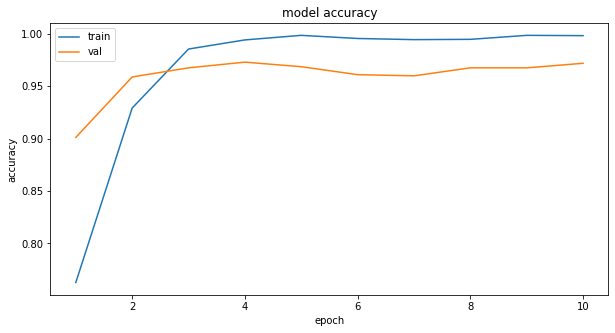

In [50]:
plt.figure(figsize=(10,5))
epochs=range(1,len(History.history['val_accuracy'])+1)

plt.plot(epochs,History.history["accuracy"])
plt.plot(epochs,History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

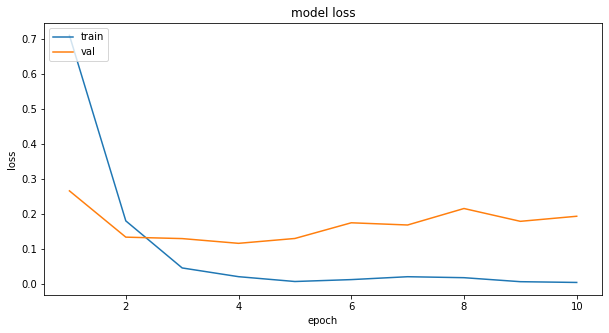

In [51]:
plt.figure(figsize=(10,5))
epochs=range(1,len(History.history['val_loss'])+1)

plt.plot(epochs,History.history["loss"])
plt.plot(epochs,History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()